In [93]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from scipy.stats import uniform
from observision_models import NormalObservation
from IPython.display import HTML

# Simulate ball throwing and generate Observations

In [94]:
from ball_throwing_simulator import BallThrowingSimulator

(61, 4, 1) (61, 2, 1)


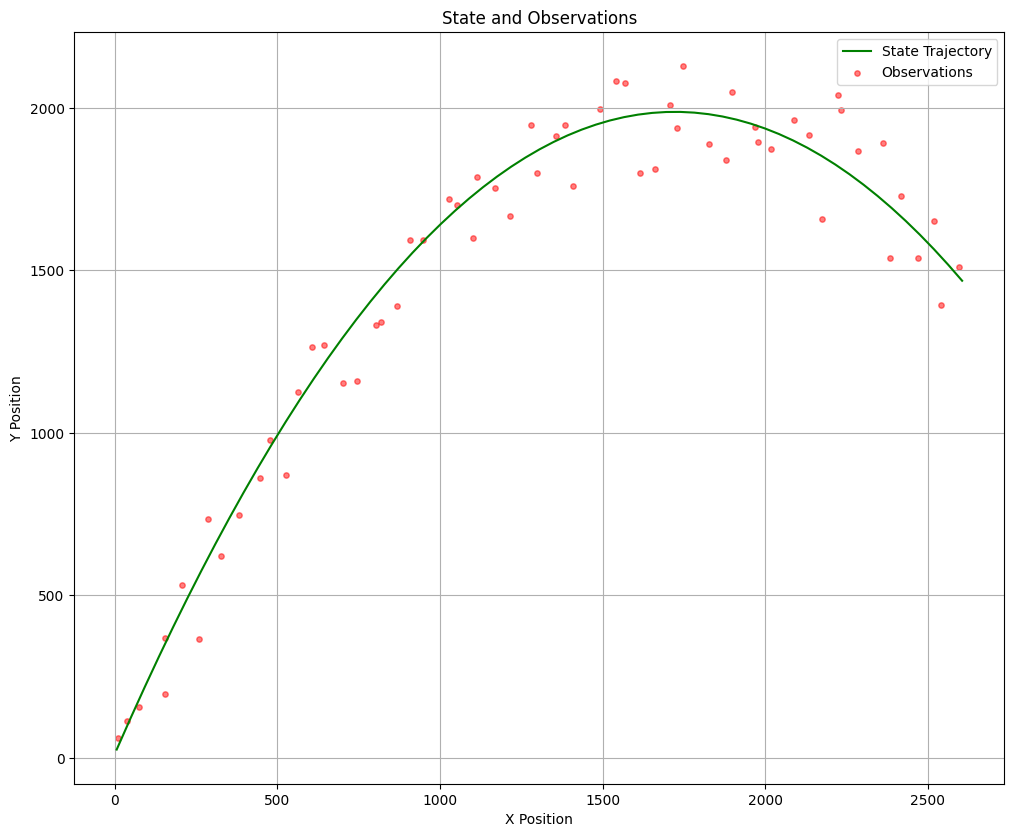

In [101]:
ball_num = 1
# init_state = np.array([[0, 0], [50,30], [100,80], [100,80]])  # Initial state: [x, y, vx, vy]
simulator = BallThrowingSimulator(delta_t=0.5, ball_num=ball_num, observation_variance=[10, 10])
# Simulate the motion and observations
states, observations = simulator.simulate(time=30)
print(states.shape, observations.shape)
# Show the simulated states and observations
fig, ax = plt.subplots(figsize=(12, 12))
plot_observations(ax, states, observations)

# Initilaize
## State
$$[X, Y, V_x, V_y]^T$$

## Uniform Random Particle Sets
$$X, Y \in [0, 3000]$$
$$V_x, V_y \in [0, 200]$$

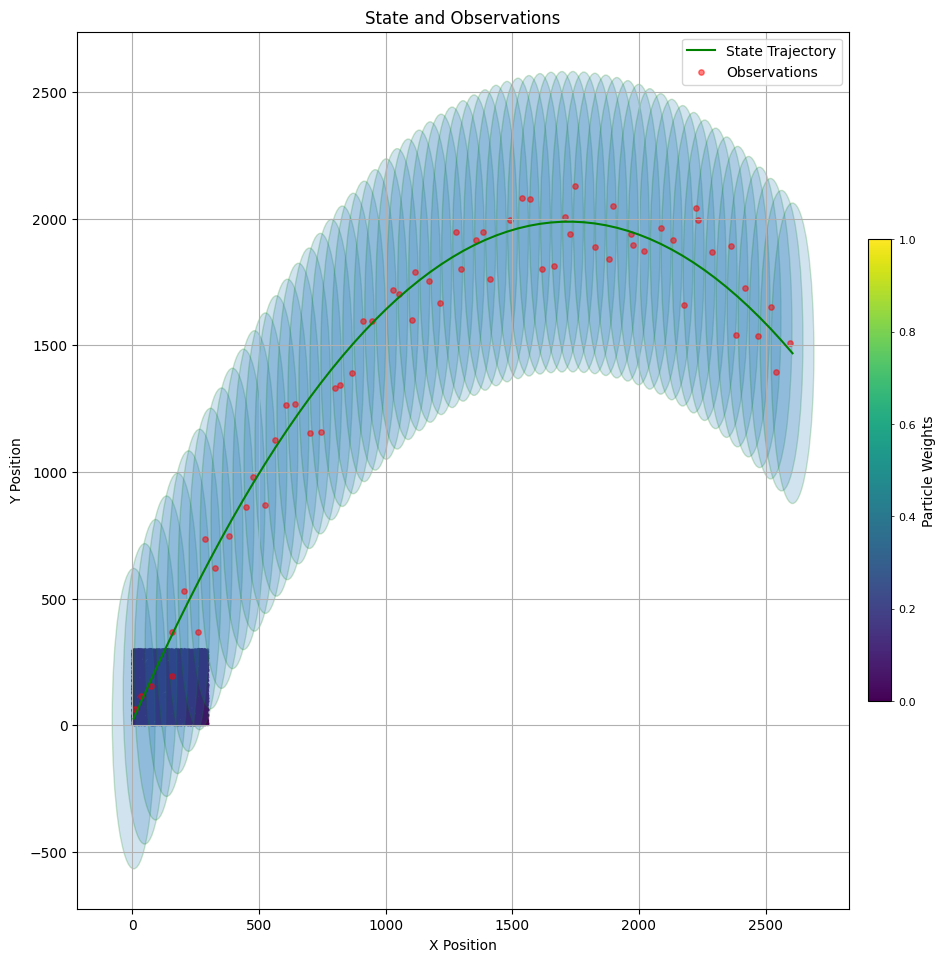

In [102]:
from partickle_filter import ParticleFilter
# initialize 1000 random particles
pf = ParticleFilter(10000)

init_particles, init_weights = pf.snaps[0]

# show initial particles
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)
ax.set_title('Initial Particles')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plot_particles(ax, init_particles, init_weights)
plot_observations(ax, states, observations, NormalObservation.R)
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


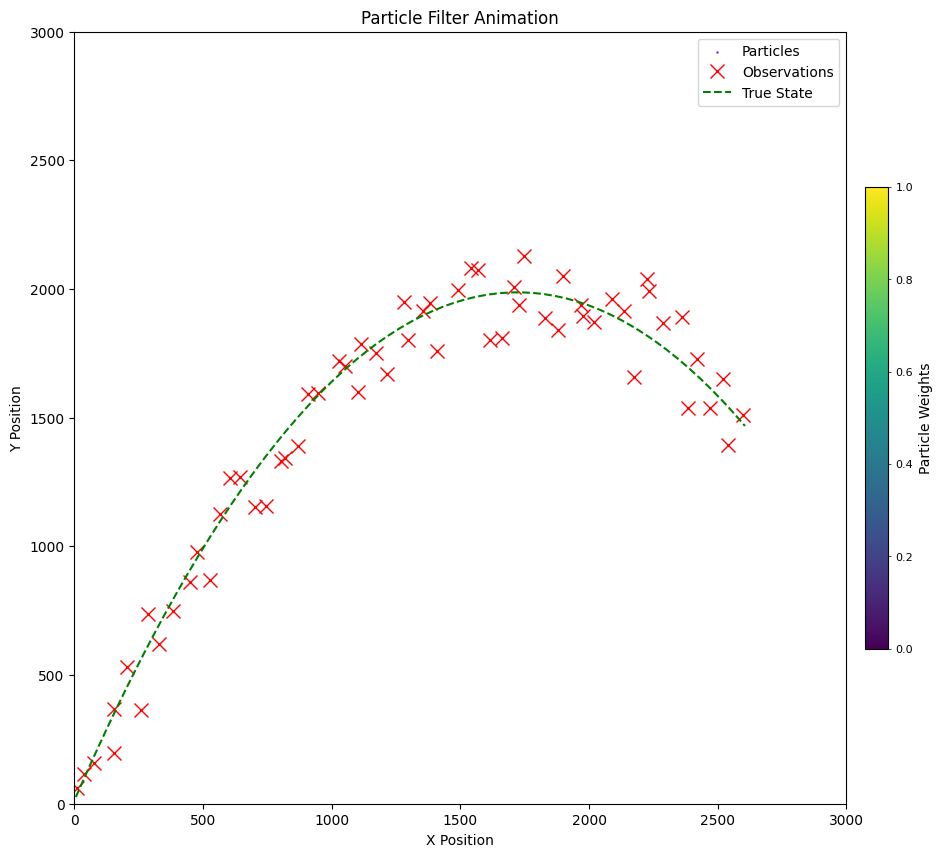

In [103]:
# 1. 初始化图表
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(0, 3000)
ax.set_ylim(0, 3000)
ax.set_title('Particle Filter Animation')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_aspect('equal', adjustable='box') # 保持坐标轴比例一致，避免椭圆变形


# 初始化用于动画的图元
# 散点图的集合 (Collection) 用于粒子，线条用于观测和真实状态
# 注意：plt.plot 返回的是一个列表，需要解包
particles_scatter = ax.scatter([], [], s=[], alpha=0.5, c='blue', label='Particles')
observations_plot, = ax.plot([], [], 'rx', markersize=10, label='Observations')
true_state_plot, = ax.plot([], [], 'g--', label='True State') # 如果有真实状态

probs_colormap = 'viridis'

sm = plt.cm.ScalarMappable(
        cmap=probs_colormap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
cbar.set_label('Particle Weights')
# make colorbar smaller
cbar.ax.tick_params(labelsize=8, length=2, width=0.5)

# 添加图例
ax.legend()

# 2. 定义更新函数
def update(frame):
    global particles, weights # 声明使用全局变量
    
    # 在第一帧（frame=0）初始化粒子和权重
    if frame == 0:
        particles, weights = pf.particles, pf.weights
    else:
        # 更新粒子和权重
        # 确保 frame 没有超出 observations 的范围
        if frame -1 < observations.shape[0]: # frame -1 是因为 frame 从0开始，而observations[i]需要i>=0
            particles, weights = pf.update(particles, weights, observations[frame-1,:])

    # 更新粒子的数据
    particles_scatter.set_offsets(particles)
    particles_scatter.set_color(colormaps.get_cmap(probs_colormap)(weights))

    # 更新观测数据，只显示到当前帧为止的观测
    current_observations = observations[:min(frame + 1, observations.shape[0])]
    observations_plot.set_data(current_observations[:, 0], current_observations[:, 1])

    # 更新真实状态数据（如果存在）
    if states is not None:
        current_states = states[:min(frame + 1, states.shape[0])]
        true_state_plot.set_data(current_states[:, 0], current_states[:, 1])

    # 返回所有需要更新的图元
    return particles_scatter, observations_plot, true_state_plot

# 3. 创建 FuncAnimation 对象
# frames: 动画的总帧数，这里是观测的数量 + 1 (为了包含初始帧)
# interval: 每帧之间的毫秒数
# blit: True 可以优化性能，只重绘变化的图元
ani = FuncAnimation(fig, update, frames=observations.shape[0] + 1, interval=100, blit=True)

# 4. 显示动画
# plt.show()
HTML(ani.to_jshtml())

ani.save('particle_filter_animation.gif', writer='imagemagick', fps=10)